In [1]:
# Notebook for SSFL mostly
import glob
import os
from typing import List, Tuple, Optional, Dict, OrderedDict
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import copy
from flwr.common import Metrics
from omegaconf import DictConfig
from flwr.server.history import History
from dataset import *
from torch.utils.data import Sampler, RandomSampler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, Subset
from torchvision.transforms import ToTensor, Compose
import time
import random
from linear_cka import linear_CKA_fast
from centr_utils import plot_results_SSL_csv
from model import SimSiam, CustomSubset
import math


In [26]:
def fit_config_fn(server_round: int):
    config_res = {}
    base_lr = 0.04
    batch_size = 128
    init_lr = base_lr * batch_size / 256
    warm_up_rounds = 10
    cos_decay = True
    if server_round < warm_up_rounds:
        # Linearly interpolate the learning rate during warm-up rounds
        cur_lr = np.linspace(0, init_lr, warm_up_rounds)[server_round]
        print(cur_lr)
    else:
        # Apply cosine decay after warm-up rounds
        if cos_decay:
            n_rounds = 800
            cur_lr = init_lr * 0.5 * (1. + math.cos(math.pi * (server_round - warm_up_rounds) / (n_rounds - warm_up_rounds)))
        else:
            cur_lr = base_lr
    
    config_res["lr"] = cur_lr
    config_res["server_round"] = server_round
    config_res["arr"] = [2, 7, 9]
    return config_res 

lrs = []
for server_round in range(150):
    config_res = fit_config_fn(server_round=server_round)
    lrs.append(config_res["lr"])
    # print(lrs[-1])
print(config_res["arr"])
plt.figure(figsize=(10, 6))
plt.plot(lrs)
plt.title('Learning Rate Schedule')
plt.xlabel('Server Round')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

In [2]:
# loss1 = float
import torch.nn as nn
# .npz kai .pt cross checkpoint loading na dw
model = SimSiam() #backbone=ResNet18().resnet, hidden_dim=2048, pred_dim=512, output_dim=2048
print(len([p for p in SimSiam().state_dict()]))
# print(model)

147


In [27]:
datapath = 'D:/Datasets/data' #'D:/DesktopC/Datasets/data/' 
subset = True #True
num_classes = 10
num_workers = 2
batch_size=128
seed=2024
num_partitions = 10
alpha = 0.5
partitioning = 'dirichlet' 
balance=True
# partitioning = 'iid'
val_ratio = 0.0

In [28]:
trainloaders, validationloaders, testloader, memoryloader, radloader = load_dataset_SSL(datapath, subset, num_classes, num_workers, 
                                                               num_partitions, batch_size, partitioning, alpha, balance, seed, rad_ratio=0.02)

{0: 15, 1: 15, 2: 15, 3: 15, 4: 15, 5: 15, 6: 15, 7: 15, 8: 15, 9: 15}


In [30]:
print(len(radloader.dataset))


150


In [9]:
# 7574.585958600044 / 60
# 0.05 * 200 / 256
5e-4

0.0005

In [9]:
print(len(trainloaders[0].dataset))
print(len(trainloaders[0]))
# print(len(trainloaders[0].dataset.dataset))
# print()
# divisor = 128 #batch_size
divisor=64

lengths = [len(loader.dataset) for loader in trainloaders]
print(f"Client's population of samples: {lengths}")
print(f"MODULO so get samples that are being left in the end of dataloader: {[len(loader.dataset) % divisor for loader in trainloaders]}") 
#[57, 8, 25, 50, 21, 50, 35, 32, 1, 53] o 9os client bgazei error me batch_size=64 kai dropparei  . #gia clients=5 k bs=128: [73, 115, 53, 24, 67]
loader_iterations = [len(loader) for loader in trainloaders]
print(f"Loader Iterations {loader_iterations}") # an zygos p.x. 14iters tote mporw x2 batchsize = 128

# if images.size(1) == 1:
#         continue  # Skip samples with channel size of 1

761
12
Client's population of samples: [761, 776, 921, 818, 533, 562, 739, 800, 833, 757]
MODULO so get samples that are being left in the end of dataloader: [57, 8, 25, 50, 21, 50, 35, 32, 1, 53]
Loader Iterations [12, 13, 15, 13, 9, 9, 12, 13, 14, 12]


In [25]:
def batches_debug(loaders):
    divisor= loaders[0].batch_size
    print(divisor)
    modulos = [len(loader.dataset) % divisor for loader in loaders]
    indexes = {i for i, num in enumerate(modulos) if num == 1}
    # count = lst.count(1)
    if len(indexes) > 0:
        for id in indexes:
            print(f"Client {id+1} will collapse during training using batch_size={divisor} because of last batch size=1.")
            print(f"MODULO to get samples that are being left in the end of dataloader: {modulos}")
            lengths = [len(loader.dataset) for loader in loaders]
            print(f"Client's population of samples: {lengths}")
            loader_iterations = [len(loader) for loader in loaders]
            print(f"Loader Iterations {loader_iterations}") # an zygos p.x. 14iters tote mporw x2 batchsize = 128
        return True
    else:
        return False
        # if 1 in modulos:
    #     print("collapse")

collapse_train = batches_debug(loaders=trainloaders) #, collapse_val , batches_debug(loaders=validationloaders)
if collapse_train: #or collapse_val: 
    print("riperino")

128


In [5]:
import torch
loss = torch.tensor(0.172)
cka = 0.5 * 0.032
total_loss = loss + cka
print(total_loss, type(total_loss))
print(float(total_loss))

list1 = [1, 3, 128]
a = 'xdd'
list2 = list1 + [a]
print(list2)

tensor(0.1880) <class 'torch.Tensor'>
0.18800000846385956
[1, 3, 128, 'xdd']


In [34]:
from model import *
print(radloader.batch_size)
print(radloader.dataset)
# print(radloader.__get_te)
model = SimSiam()
print(model.encoder[1].l3[0].out_features)# self.encoder[1].l3[0].out_features
phi_K = torch.zeros(len(radloader.dataset), model.encoder[1].l3[0].out_features)
print(type(phi_K), phi_K.size(), phi_K)
# print(model)
# model = model.to('cuda')
# parameters = [{
#         'name': 'base',
#         'params': [param for name, param in model.named_parameters() if not name.startswith(predictor_prefix)],
#         'lr': lr
#     },{
#         'name': 'predictor',
#         'params': [param for name, param in model.named_parameters() if name.startswith(predictor_prefix)],
#         'lr': lr
#     }]


128
2048
<class 'torch.Tensor'> torch.Size([150, 2048]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [22]:
list1 = [1, 4, 7, 9, 8]
print(list1[:-1])
print(list1[-1])
obj1 = np.random.randn(40,50)
obj3 = np.random.randn(40,50)
obj2 = np.random.rand(150,2048)
list_obj = []
list_obj.append(obj1)
list_obj.append(obj3)
list_obj.append(obj2)
obj4 = None
# list_obj.append(obj4)
# print(list_obj[-1])
print(len(list_obj))
for obj in list_obj:
    print(obj.shape)

list_obj.append(obj4)
# list_obj.extend(obj4) # error

[1, 4, 7, 9]
8
3
(40, 50)
(40, 50)
(150, 2048)


In [34]:
print(len(radloader.dataset))
len_params = len(model.state_dict())
tr_params = [name for name, _ in model.named_parameters()]
print(tr_params) 
print(f"Trainable parameters:{len(tr_params)}")  #trainable parameters: 68 exei o encoder , 6 exei o predictor pou 8a exoun constant_lr
# print(f"Total: {len_params}, Backbone: {len(model.backbone.state_dict())}, Encoder: {len(model.encoder.state_dict())}, Predictor: {len(model.predictor.state_dict())}")
print(f"Total: {len_params}, Backbone: {len(model.encoder[0].state_dict())},Projector: {len(model.encoder[1].state_dict())} Encoder: {len(model.encoder.state_dict())}, Predictor: {len(model.predictor.state_dict())}")
print(len(model.encoder[0].state_dict()))
# print(model.encoder[0])

print(model.encoder[1].l3[0].out_features)
# len(model.backbone)
# len(model.encoder)
# len(model.predictor)
predictor_prefix = ('module.predictor', 'predictor')
lr = 1e-3
parameters = [{
        'name': 'base',
        'params': [param for name, param in model.named_parameters() if not name.startswith(predictor_prefix)],
        'lr': lr
    },{
        'name': 'predictor',
        'params': [param for name, param in model.named_parameters() if name.startswith(predictor_prefix)],
        'lr': lr
    }]

print(type(parameters[1]))
print(len(parameters[0]['params']))
print(len(parameters[1]['params']))

150
['encoder.0.conv1.weight', 'encoder.0.bn1.weight', 'encoder.0.bn1.bias', 'encoder.0.layer1.0.conv1.weight', 'encoder.0.layer1.0.bn1.weight', 'encoder.0.layer1.0.bn1.bias', 'encoder.0.layer1.0.conv2.weight', 'encoder.0.layer1.0.bn2.weight', 'encoder.0.layer1.0.bn2.bias', 'encoder.0.layer1.1.conv1.weight', 'encoder.0.layer1.1.bn1.weight', 'encoder.0.layer1.1.bn1.bias', 'encoder.0.layer1.1.conv2.weight', 'encoder.0.layer1.1.bn2.weight', 'encoder.0.layer1.1.bn2.bias', 'encoder.0.layer2.0.conv1.weight', 'encoder.0.layer2.0.bn1.weight', 'encoder.0.layer2.0.bn1.bias', 'encoder.0.layer2.0.conv2.weight', 'encoder.0.layer2.0.bn2.weight', 'encoder.0.layer2.0.bn2.bias', 'encoder.0.layer2.0.downsample.0.weight', 'encoder.0.layer2.0.downsample.1.weight', 'encoder.0.layer2.0.downsample.1.bias', 'encoder.0.layer2.1.conv1.weight', 'encoder.0.layer2.1.bn1.weight', 'encoder.0.layer2.1.bn1.bias', 'encoder.0.layer2.1.conv2.weight', 'encoder.0.layer2.1.bn2.weight', 'encoder.0.layer2.1.bn2.bias', 'encode

In [53]:
512*512*0.75
# 0.75* 512 # 384
# 0.4... 1 . MO= 0.7
# 0.7 * 512 # 358
# 0.6* 512 = 307
# 0.65* 512 = 332
0.2 * 512
# 59* 128 # 7500 subset 10 classes
# 687 / 60 # 11.45wres
(2.32 + 0.14) * 200 # 492 mins  #* 60


492.0

In [3]:
mu =0.5
# print(len(memoryloader.dataset))
# len(radloader.dataset)
state = False
for i in range(10):
    if i == 10-1:
        print(i)
    # b = 20 + 5
#     if state:
#         b = 30
string1 = 'progress'
print(string1 + '2')
# print(b)

9
progress2


In [12]:
embds = []
with torch.no_grad():
    model.to('cpu')
    for idx, (X_img , _) in enumerate(radloader):
        # images = data[0] # images[0]
        # model.to('cpu')
        embedding = model.encoder(X_img) #.cuda(non_blocking=True)) # +1000MB sthn gpu
        print(embedding.size(), embedding.device)
        embds.append(embedding)
        # if idx == 2:
        #     break 
        # features_list.append(embedding.cpu().numpy())
        # 0.6 seconds pairnei to forward pass . xanw sta 2crops augmentations 8.8 secs. Glytwnw 3 secs gia xwris augmentation otan pairnw subsampled apo memoryset simple trf format.
        # 4.8 me simple_trf dataset, 5.6 sec me one crop augmentation trf
    # K2 = torch.cat(embds, dim=0)
    K = torch.cat(embds, dim=0)
    # linear_CKA_fast()

print(embedding[0])
print(embedding[1])
model = model.to('cuda') 


torch.Size([32, 2048]) cpu
torch.Size([32, 2048]) cpu
torch.Size([32, 2048]) cpu
torch.Size([32, 2048]) cpu
torch.Size([22, 2048]) cpu
tensor([-0.5867, -0.8563,  1.7407,  ...,  0.4323,  0.2128,  0.4134])
tensor([ 0.1234,  0.5639, -1.1866,  ...,  0.8113, -2.0471,  0.3632])


In [ ]:
def _set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [ ]:
phi_Ks = [K, K]

In [55]:
# trainloaders, validationloaders, testloader = load_centr_data_SSL(datapath, subset, num_classes, num_workers, num_partitions, batch_size, partitioning)
augmentation = Compose([
        RandomResizedCrop(256, scale=(0.2, 1.), interpolation= F.InterpolationMode.BICUBIC),
        RandomApply([
            ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
        ], p=0.8),
        RandomGrayscale(p=0.2),
        RandomHorizontalFlip(),
        ToTensor(),
        # normalize
    ])
simple_trf = Compose([
    Resize((256, 256), interpolation= F.InterpolationMode.BICUBIC),
    ToTensor(),
])
trainset, testset, memoryset = get_food101_ssl(augmentation, simple_trf, datapath, subset, num_classes)


<class 'torchvision.datasets.food101.Food101'>


In [53]:

np.random.seed(seed=seed)
rad_ratio = 0.02
train_indices, val_indices = train_test_split(trainset.indices, test_size=rad_ratio, stratify=trainset.labels)
radset = CustomSubset(trainset.dataset, val_indices)
print(radset)
print(radset.indices[:30])
tmp = get_subset_stats(radset)
print(tmp)
# print()

[62818 21227 62916  5930 33111 21012 11804 45021 45186 12933 16937 16954
 62511 13298 13196 12670 11540 33380 13398 17244 45674 21718 33488 12160
 16670 45574 33517 45096 11440 29735]
{0: 15, 1: 15, 2: 15, 3: 15, 4: 15, 5: 15, 6: 15, 7: 15, 8: 15, 9: 15}


In [49]:
print(len(trainset), len(train_indices), len(val_indices))
# print(val_indices)


7500 7350 150
{0: 15, 1: 15, 2: 15, 3: 15, 4: 15, 5: 15, 6: 15, 7: 15, 8: 15, 9: 15}


In [18]:
print(type(trainset))
print(memoryset.indices)
print(len(memoryset.indices))

<class 'dataset.CustomSubset'>
[ 5250  5251  5252 ... 62997 62998 62999]
7500


In [86]:
# def load_alignment():
#     "Load representation alignment dataset which is publicly seen to clients."
#     # indices randperm

# def load_dataset_SSL(datapath: str, 
#                  subset: bool,
#                  num_classes: int,
#                  num_workers: int,
#                  num_partitions: int, 
#                     batch_size: int,
#                     partitioning: str = "iid", 
#                     alpha: float = 0.5,
#                     balance: bool = True,
#                     seed: int = 2024,
#                     val_ratio: float = 0.0,
#                     rad_ratio: float = 0.02):
#     """Download Food101 and generate partitions & loaders for federating self-supervised learning."""
#     augmentation = Compose([
#         RandomResizedCrop(256, scale=(0.2, 1.), interpolation= F.InterpolationMode.BICUBIC),
#         RandomApply([
#             ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
#         ], p=0.8),
#         RandomGrayscale(p=0.2),
#         RandomHorizontalFlip(),
#         ToTensor(),
#         # normalize
#     ])
#     simple_trf = Compose([
#         Resize((256, 256), interpolation= F.InterpolationMode.BICUBIC),
#         ToTensor(),
#     ])
#     trainset, testset, memoryset = get_food101_ssl(augmentation, simple_trf, datapath, subset, num_classes)

#     if partitioning == "iid":
#         trainsets = partitioning_iid(trainset, num_partitions, balance, seed)
#         title_str = f"Clients data partitioning: {partitioning.upper()}"
#         if balance:
#             save_str_cid: str ="balanced" # equal splits per client based on each label quantity
#         else:
#             save_str_cid: str ="U" #uniform shuffle rand generator
#         save_str_exp = f"images/clients_vis/{partitioning}/clients_{len(trainsets)}/classes_{num_classes}/{save_str_cid}/summary" #clients_{len(trainsets)}_classes_{num_classes}_
#     elif partitioning == "dirichlet":
#         trainsets = partitioning_dirichlet(alpha, trainset, num_partitions, seed)
#         title_str = f"Clients data partitioning: {partitioning.upper()}, a={alpha}"
#         save_str_cid: str = (f"a_{alpha}")
#         save_str_exp = f"images/clients_vis/{partitioning}/clients_{len(trainsets)}/classes_{num_classes}/{save_str_cid}/summary" #alpha_{alpha}_clients_{len(trainsets)}_classes_{num_classes}_
#     else:
#         raise NotImplementedError(f"{partitioning} partitioning not done")


#     # Obtain and save data statistic plots
#     if not os.path.exists(f'./images/clients_vis/{partitioning}/clients_{len(trainsets)}/classes_{num_classes}/{save_str_cid}'):
#             os.makedirs(f'./images/clients_vis/{partitioning}/clients_{len(trainsets)}/classes_{num_classes}/{save_str_cid}')
#     plot_exp_summary(trainsets, title_str, num_classes, save_str_exp)
#     for c_id, sub_trainset in enumerate(trainsets):
#         tmp = get_subset_stats(sub_trainset)
#         plot_client_stats(partitioning, c_id+1, tmp, num_classes, save_str_cid, save_str_exp)
    
#     # trainsets on IID case if balance=False
#     # create dataloaders with train+val support
#     trainloaders: list[CustomSubset] = []
#     valloaders: list[CustomSubset] = []
#     np.random.seed(seed)
#     for c_id, trainset_ in enumerate(trainsets):
#         if balance and val_ratio != 0:
#             if partitioning =="iid":
#                 train_indices, val_indices = train_test_split(trainset_.indices, test_size=val_ratio, stratify=trainset_.labels)
                
#                 trainloaders.append(CustomSubset(trainset_.dataset, train_indices))
#                 valloaders.append(CustomSubset(trainset_.dataset, val_indices))
#                 tmp = get_subset_stats(trainloaders[-1])
#                 plot_client_stats(partitioning, c_id+1, tmp, num_classes, save_str_cid + "_train", save_str_exp+ "_train", split="train")
#                 tmp = get_subset_stats(valloaders[-1])
#                 plot_client_stats(partitioning, c_id+1, tmp, num_classes, save_str_cid + "_val", save_str_exp+ "_val", split="val")
#             else: #dirichlet
#                 # Get unique class labels and their counts
#                 unique_labels, class_counts = np.unique(trainset_.labels, return_counts=True)
#                 # Define a minimum threshold for the number of samples in each class
#                 min_samples_per_class = 2
#                 # Filter out classes with too few samples
#                 filtered_classes = [label for label, count in zip(unique_labels, class_counts) if count >= min_samples_per_class]
#                 # Filter indices corresponding to the filtered classes
#                 filtered_indices = [index for index, label in enumerate(trainset_.labels) if label in filtered_classes]
#                 # Split filtered (X,y)
#                 train_indices, val_indices = train_test_split(trainset_.indices[filtered_indices], test_size=val_ratio, stratify=trainset_.labels[filtered_indices])
#                 # Get the excluded indices
#                 excluded_indices = [index for index in range(len(trainset_.labels)) if index not in filtered_indices]
#                 train_indices = np.concatenate((train_indices, np.array(trainset_.indices[excluded_indices])))

#                 trainloaders.append(CustomSubset(trainset_.dataset, train_indices))
#                 valloaders.append(CustomSubset(trainset_.dataset, val_indices))
#                 tmp = get_subset_stats(trainloaders[-1])
#                 plot_client_stats(partitioning, c_id+1, tmp, num_classes, save_str_cid + "_train", save_str_exp+ "_train", split="train")
#                 tmp = get_subset_stats(valloaders[-1])
#                 plot_client_stats(partitioning, c_id+1, tmp, num_classes, save_str_cid + "_val", save_str_exp+ "_val", split="val")
#         else: #uni split if not balanced split requested
#             num_total = len(trainset_)
#             num_val = int(val_ratio * num_total)
#             num_train = num_total - num_val
            
#             # choose validation indexes
#             choices = np.random.choice(range(num_total), size=num_val, replace=False)
#             # boolean split
#             idxs_val = np.zeros(num_total, dtype=bool)
#             idxs_val[choices] = True
#             idxs_tr = ~idxs_val
#             # In this way, the i-th client will get the i-th element in the trainloaders list and the i-th element in the valloaders list
#             trainloaders.append(CustomSubset(trainset_.dataset, trainset_.indices[idxs_tr]))
#             tmp = get_subset_stats(trainloaders[-1])
#             plot_client_stats(partitioning, c_id+1, tmp, num_classes, save_str_cid + "_train", save_str_exp+ "_train", split="train")
#             if val_ratio !=0:
#                 valloaders.append(CustomSubset(trainset_.dataset, trainset_.indices[idxs_val]))
#                 tmp = get_subset_stats(valloaders[-1])
#                 plot_client_stats(partitioning, c_id+1, tmp, num_classes, save_str_cid + "_val", save_str_exp+ "_val", split="val")

#     # construct data loaders to their respective list
#     trainloaders = [DataLoader(Subset(trainloaders[i].dataset, trainloaders[i].indices), batch_size=batch_size, 
#                                     shuffle=True, num_workers=num_workers) 
#                          for i in range(len(trainloaders))]
#     if val_ratio !=0:
#         valloaders = [DataLoader(Subset(valloaders[i].dataset, valloaders[i].indices), batch_size=batch_size, 
#                                         shuffle=True, num_workers=num_workers) 
#                             for i in range(len(valloaders))]
#     else:
#         valloaders = [None] * num_partitions
#     # testloader = DataLoader(testset, batch_size=batch_size, num_workers=num_workers)
#     testloader = DataLoader(Subset(testset.dataset, testset.indices), batch_size=batch_size, num_workers=num_workers)
#     # Load representation alignment dataset which is publicly loaded from clients
#     train_indices, val_indices = train_test_split(trainset.indices, test_size=rad_ratio, stratify=trainset.labels)
#     radset = CustomSubset(trainset.dataset, val_indices)
#     # rad_stats = get_subset_stats(radset)
#     # print(rad_stats)
#     radloader = DataLoader(Subset(radset.dataset, radset.indices), batch_size=batch_size, num_workers=num_workers)
#     # memoryloader-artificial knowledge for monitoring 
#     memoryloader = DataLoader(Subset(memoryset.dataset, memoryset.indices), batch_size=batch_size, num_workers=num_workers) 
#     return trainloaders, valloaders, testloader, memoryloader, radloader
    
    

In [73]:
print(validationloaders)
print(validationloaders[0])
print(trainloaders)

[None, None, None, None, None, None, None, None, None, None]
None
[<torch.utils.data.dataloader.DataLoader object at 0x000001F213FA5600>, <torch.utils.data.dataloader.DataLoader object at 0x000001F20FA9AFB0>, <torch.utils.data.dataloader.DataLoader object at 0x000001F20FA9B100>, <torch.utils.data.dataloader.DataLoader object at 0x000001F20FA9B8E0>, <torch.utils.data.dataloader.DataLoader object at 0x000001F20FA9B940>, <torch.utils.data.dataloader.DataLoader object at 0x000001F20FA84130>, <torch.utils.data.dataloader.DataLoader object at 0x000001F20FA85660>, <torch.utils.data.dataloader.DataLoader object at 0x000001F20FA858D0>, <torch.utils.data.dataloader.DataLoader object at 0x000001F20FA85720>, <torch.utils.data.dataloader.DataLoader object at 0x000001F20FA85A80>]


In [12]:

import torchvision.transforms.functional as F
net = ResNet18(num_classes)
# print(net)
# print(net.resnet)
print(net.resnet.fc.in_features)
print(net.resnet.layer4[-1].conv2.out_channels) #.conv3.out_channels)

model = SimSiam(backbone=net.resnet, hidden_dim=2048, pred_dim=512, output_dim=2048)
# backbone.fc = ProjectionMLP(backbone.layer4[-1].conv2.out_channels, hidden_dim, hidden_dim, hidden_dim) 
#         self.encoder = backbone
# print(model)
print(model.encoder)
print(model.encoder[1].l3[0].out_features) #.out_features)

inp = torch.randn(64, 3, 256, 256)
feature = model.encoder[0](inp)
print(feature.size())
# print(F.normalize(feature, dim=1))

512
512
Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [31]:
from torchvision.transforms import ToTensor, Normalize, Compose, RandomResizedCrop, RandomApply, ColorJitter, RandomGrayscale, RandomHorizontalFlip, Resize
import torchvision.transforms.functional as F
# from .functional import F
# def resize_img(img):
#     return F.resize(img, size=224, interpolation=F.InterpolationMode.BILINEAR) #BICUBIC
# 224 , 256, 384
augmentation = Compose([
        RandomResizedCrop(256, scale=(0.4, 1.), interpolation= F.InterpolationMode.BICUBIC),
        RandomApply([
            ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
        ], p=0.8),
        RandomGrayscale(p=0.2),
        RandomHorizontalFlip(),
        ToTensor(),
        # normalize
    ])
simple_trf = Compose([
    # Resize(224, F.InterpolationMode.BICUBIC),
    Resize((256, 256), interpolation= F.InterpolationMode.BICUBIC),
    ToTensor(),
    # resize_img, # avoid pickling error
])
# F.resize(image, [224, 224])

In [40]:
trainset = Food101(root=datapath, split="train", transform=TwoCropsTransform(augmentation), download= True)
testset = Food101(root=datapath, split="test", transform=simple_trf, download= True)
memoryset = Food101(root=datapath, split="train", transform=simple_trf, download= True)
print(type(trainset))
# print(type(testset))
if subset:
        #Taking Subset of trainset and testset
        # select classes you want to include in your subset
        list = [i for i in range(num_classes)]
        classes = torch.tensor(list)
        # get indices that correspond to one of the selected classes
        train_indices = (torch.tensor(trainset._labels)[..., None] == classes).any(-1).nonzero(as_tuple=True)[0]
        np_tr_idx = np.array(train_indices)
        # subset the dataset
        train_sub = CustomSubset(trainset, np_tr_idx) # tr_mapped_lab)
        # get indices that correspond to one of the selected classes
        test_indices = (torch.tensor(testset._labels)[..., None] == classes).any(-1).nonzero(as_tuple=True)[0]
        np_test_idx = np.array(test_indices)
        # subset the dataset
        test_sub = CustomSubset(testset, np_test_idx) #, test_mapped_lab)
        # test_sub = Subset(testset, test_indices)
        memory_indices = (torch.tensor(memoryset._labels)[..., None] == classes).any(-1).nonzero(as_tuple=True)[0]
        np_memory_idx = np.array(memory_indices)
        memory_sub = CustomSubset(memoryset, np_memory_idx)
else:
    raise ValueError('subset')

print(type(train_sub))
print(train_sub.dataset)
trainset = train_sub
testset = test_sub
memoryset = memory_sub

<class 'torchvision.datasets.food101.Food101'>
<class 'dataset.CustomSubset'>
Dataset Food101
    Number of datapoints: 75750
    Root location: D:/Datasets/data
    split=train
    StandardTransform
Transform: <dataset.TwoCropsTransform object at 0x00000296B2D2F730>


In [37]:
print(trainset.indices)
print(memoryset.indices)

[ 5250  5251  5252 ... 62997 62998 62999]
[ 5250  5251  5252 ... 62997 62998 62999]


In [38]:

train_loader = DataLoader(Subset(trainset.dataset, trainset.indices), batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(Subset(testset.dataset, testset.indices), batch_size=batch_size, num_workers=num_workers)
memory_loader = DataLoader(Subset(memoryset.dataset, memoryset.indices), batch_size=batch_size, num_workers=num_workers)

In [7]:
print(type(test_loader))
for X, y in test_loader:
    print(X.size())
    break

for (X, _) in train_loader:
    print(X[0].size(), X[1].size())
    break 

<class 'torch.utils.data.dataloader.DataLoader'>
torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 256, 256]) torch.Size([32, 3, 256, 256])


In [39]:
# print(memory_loader.dataset.indices)
# # print(memory_loader.dataset.labels)
# print(len(memory_loader.dataset.indices))
# print(memory_loader.dataset)
# print(memory_loader.dataset.dataset._labels)
# print(len(memory_loader.dataset.dataset._labels))


# print(classes)
# print(tr_mapped_lab)
# print(len(tr_mapped_lab))
# print(len(memory_loader.dataset))


targets = np.array(memory_loader.dataset.dataset._labels)[memory_loader.dataset.indices] 
classes = len(np.unique(targets))
print(classes)
print(targets)
print(len(targets))

10
[4 4 4 ... 9 9 9]
7500


In [86]:
from utils import get_subset_stats
from typing import List, Dict
sample_counts = get_subset_stats(trainset)
label_to_index = trainset.dataset.class_to_idx
# print(label_to_index)
# print(sample_counts)
# print(sorted(sample_counts.keys()))
# print(label_to_index.values())
final_dict = {value: key for key, value in label_to_index.items() if value in sample_counts}
print(final_dict)
# final_dict = {}

{0: 'apple_pie', 1: 'baby_back_ribs', 2: 'baklava', 3: 'beef_carpaccio', 4: 'beef_tartare', 5: 'beet_salad', 6: 'beignets', 7: 'bibimbap', 8: 'bread_pudding', 9: 'breakfast_burrito'}


In [87]:
# Create histograms for each channel
def hist_rgb(img_array: np.ndarray, save_str: str):
    rgb_dict = {0: "Red", 1: "Green", 2: "Blue"}
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    # Loop over each channel
    for i in range(3):
        # Flatten the channel array to create a 1D array containing all pixel values of the channel
        channel_values = img_array[:, :, i].flatten()
        # Create a histogram for the channel and plot it on the corresponding subplot
        axs[i].hist(channel_values, bins=50, color=['red', 'green', 'blue'][i], alpha=0.7)
        # Set titles and labels for each subplot
        axs[i].set_title(f"{rgb_dict[i]} channel histogram") #{i+1}
        axs[i].set_xlabel('Pixel Value')
        axs[i].set_ylabel('Frequency')

    # Set the overall title for the figure
    fig.suptitle('Histograms of pixels for each channel')
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.savefig(f"images/preproc/ssl_hist_RGB_{save_str}", bbox_inches='tight')
    # Show the plot
    plt.show()

def object_printer(img, img_label, i, trf = False):
    img_class = int(img_label) # - 1
    # Convert the PIL image object to a NumPy array
    # for img in img_object[0]:
    print(img.size())
    img_array = np.array(img)
    print(img_array.shape) # HxWxC  if trf=True has tensor format CHW
    save_str = f"{final_dict[img_class]}_{i}"
    shape_str = f"{img_array.shape}"
    if trf:
        shape_str = f"Tensor {shape_str}"
        img_array = np.transpose(img_array, (1, 2, 0))
        save_str = f"trf_{save_str}"
    
    # Display the image using Matplotlib
    plt.imshow(img_array)
    plt.title(f'{shape_str} image of {final_dict[img_class]}')
    plt.axis('off')  # Turn off axis labels
    plt.savefig(f"images/preproc/ssl_img_{save_str}", bbox_inches='tight')
    plt.show()

    hist_rgb(img_array=img_array, save_str=save_str)
    return i+1

torch.Size([32, 3, 256, 256]) torch.Size([32, 3, 256, 256]) torch.Size([32]) tensor(4)
torch.Size([3, 256, 256])
(3, 256, 256)


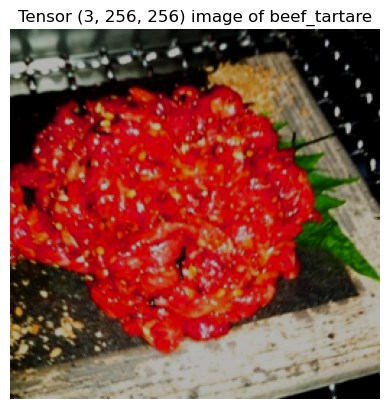

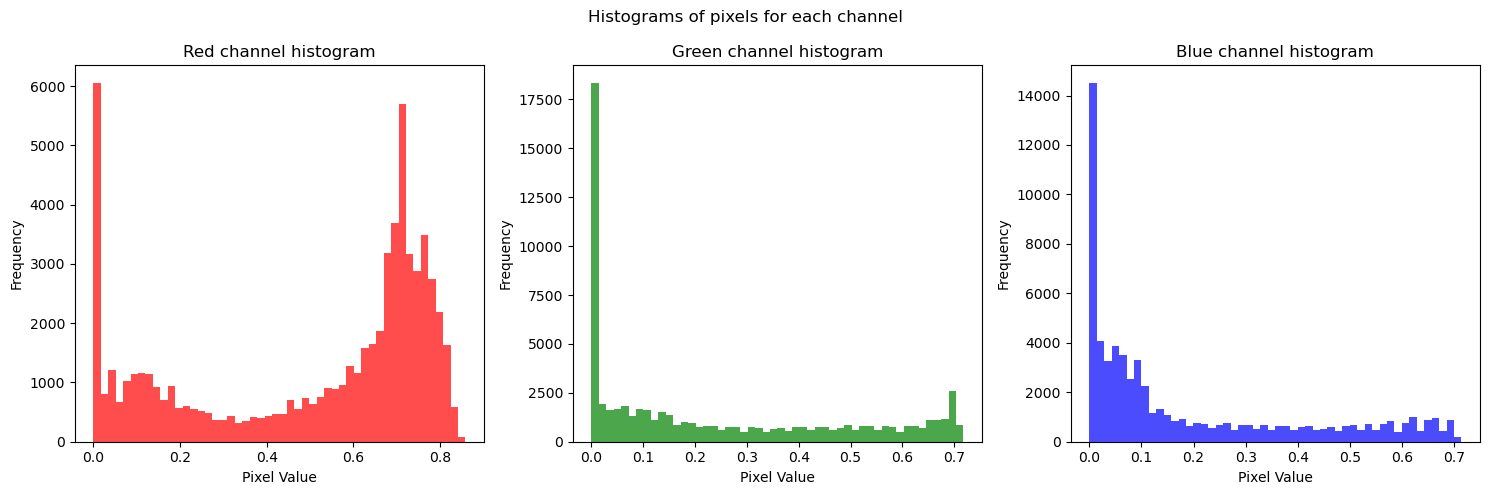

1
torch.Size([3, 256, 256])
(3, 256, 256)


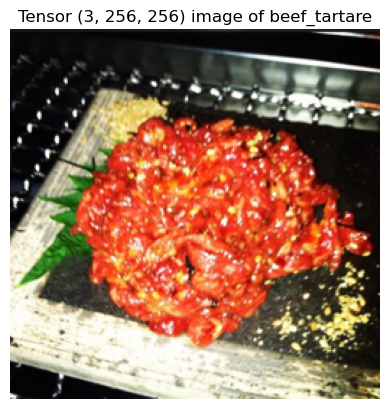

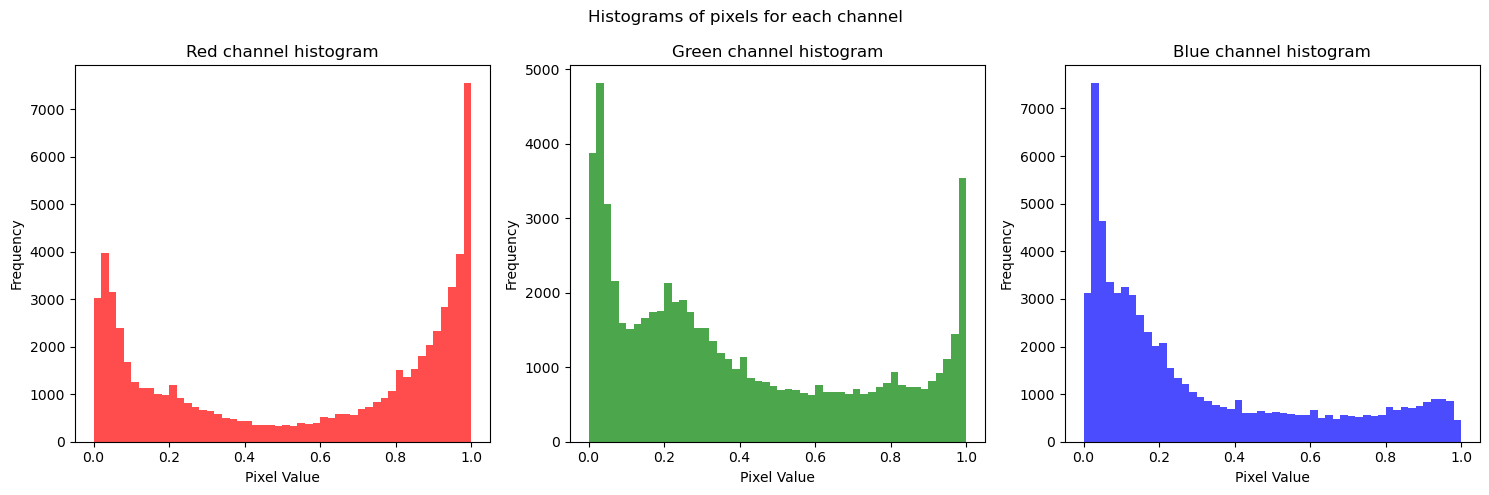

In [88]:
i = 0
# for X, y in test_loader:
#     print(X.size(), X[0].size(), y.size(), y[0])
#     object_printer(X[0], y[0], i, trf = True)
#     break
for X, y in train_loader:
    print(X[0].size(), X[1].size(), y.size(), y[0])
    i = object_printer(X[0][0], y[0], i, trf = True)
    print(i)
    object_printer(X[1][0], y[0], i, trf = True)
    break 


In [ ]:

for i, data in enumerate(test_loader):
    imgs, _ = data
    print(len(imgs), type(imgs))
    break
    if i == 1:
        break